In [18]:
import numpy as np
import pandas as pd

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error

import lightgbm as lgb
try:
    import xgboost as xgb
    HAS_XGB = True
except ImportError:
    HAS_XGB = False

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

plt.style.use("seaborn-v0_8-whitegrid")
sns.set_context("notebook", font_scale=1.1)

DATA_PATH = Path("../data")

train_df = pd.read_csv(DATA_PATH / "train.csv").sort_values("date_id").reset_index(drop=True)
print(train_df.shape)
train_df.head()

plt.style.use("seaborn-v0_8-whitegrid")
sns.set_context("notebook", font_scale=1.1)

DATA_PATH = Path("../data")

train_df = pd.read_csv(DATA_PATH / "train.csv").sort_values("date_id").reset_index(drop=True)
print(train_df.shape)
train_df.head()

(9021, 98)
(9021, 98)


,date_id,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V3,V4,V5,V6,V7,V8,V9,forward_returns,risk_free_rate,market_forward_excess_returns
0,0,0,0,0,1,1,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002421,0.000301,-0.003038
1,1,0,0,0,1,1,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.008495,0.000303,-0.009114
2,2,0,0,0,1,0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.009624,0.000301,-0.010243
3,3,0,0,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004662,0.000299,0.004046
4,4,0,0,0,1,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.011686,0.000299,-0.012301


In [20]:
def generate_FE_interaction_regime(df, target_col="market_forward_excess_returns"):
    df = df.copy()

    # ==========================
    # 1) Lag Features
    # ==========================
    lags = [1, 2, 5, 10, 21, 63]
    for l in lags:
        df[f"{target_col}_lag{l}"] = df[target_col].shift(l)

    # ==========================
    # 2) Rolling Statistics
    # ==========================
    windows = [5, 10, 21, 63]
    for w in windows:
        df[f"roll_mean_{w}"] = df[target_col].rolling(w).mean()
        df[f"roll_std_{w}"] = df[target_col].rolling(w).std()
        df[f"roll_min_{w}"] = df[target_col].rolling(w).min()
        df[f"roll_max_{w}"] = df[target_col].rolling(w).max()
        df[f"zscore_{w}"] = (df[target_col] - df[f"roll_mean_{w}"]) / df[f"roll_std_{w}"]

    # ==========================
    # 3) Volatility Regime (High/Low + Crisis)
    # ==========================
    df["vol21"] = df[target_col].rolling(21).std()
    df["vol63"] = df[target_col].rolling(63).std()

    df["high_vol"] = (df["vol21"] > df["vol63"]).astype(int)
    df["crisis"] = (df["vol21"] > df["vol21"].quantile(0.9)).astype(int)

    # volatility slope (change in vol regime)
    df["vol_slope"] = df["vol21"] / (df["vol63"] + 1e-9)

    # ==========================
    # 4) Macro Shock Regime
    # ==========================
    macro_cols = [c for c in df.columns if c.startswith("E")]  # 'E' 계열 = macro
    for col in macro_cols:
        df[f"{col}_z"] = (df[col] - df[col].rolling(63).mean()) / (df[col].rolling(63).std() + 1e-9)
        df[f"{col}_shock"] = (abs(df[f"{col}_z"]) > 2).astype(int)

    # global macro shock (aggregated)
    shock_cols = [c for c in df.columns if c.endswith("_shock")]
    df["macro_shock_sum"] = df[shock_cols].sum(axis=1)
    df["macro_crisis"] = (df["macro_shock_sum"] >= 3).astype(int)

    # ==========================
    # 5) Momentum / Volatility Interaction
    # ==========================
    momentum_cols = [c for c in df.columns if c.startswith("M")]
    vol_cols = [c for c in df.columns if c.startswith("V")]

    # momentum × volatility
    for m in momentum_cols[:5]:        # 너무 많으면 차원 폭발 → top 5만
        for v in vol_cols[:5]:
            df[f"{m}_x_{v}"] = df[m] * df[v]

    # ==========================
    # 6) Macro Spread Interaction (강력한 factor)
    # ==========================
    macro_pairs = [("E2", "E11"), ("E7", "E12"), ("E3", "E5")]
    for a, b in macro_pairs:
        if a in df.columns and b in df.columns:
            df[f"{a}_minus_{b}"] = df[a] - df[b]

    # ==========================
    # 7) Return Shock Indicators
    # ==========================
    df["return_shock"] = (abs(df[target_col]) > df[target_col].std() * 2).astype(int)

    # ==========================
    # 8) Cleanup: Drop NaN from rolling/lags
    # ==========================
    df = df.dropna().reset_index(drop=True)
    return df

In [21]:
def ts_cv_models_no_leakage(
    fe_df,
    target_col="market_forward_excess_returns",
    pca_components=15,
    n_splits=5
):
    X_raw = fe_df.drop(columns=[target_col]).values
    y = fe_df[target_col].values

    tscv = TimeSeriesSplit(n_splits=n_splits)

    results = {
        "ElasticNet": {"rmse": [], "corr": []},
        "LightGBM": {"rmse": [], "corr": []},
    }
    if HAS_XGB:
        results["XGBoost"] = {"rmse": [], "corr": []}

    for fold, (train_idx, val_idx) in enumerate(tscv.split(X_raw), start=1):
        print(f"\n=== Fold {fold}/{n_splits} ===")

        X_tr_raw, X_val_raw = X_raw[train_idx], X_raw[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]

        # ---------- ElasticNet: StandardScaler + PCA (fold마다 fit) ----------
        scaler = StandardScaler()
        X_tr_scaled = scaler.fit_transform(X_tr_raw)
        X_val_scaled = scaler.transform(X_val_raw)

        pca = PCA(n_components=pca_components, random_state=42)
        X_tr_pca = pca.fit_transform(X_tr_scaled)
        X_val_pca = pca.transform(X_val_scaled)

        enet = ElasticNet(alpha=1e-3, l1_ratio=0.1, max_iter=5000, random_state=42)
        enet.fit(X_tr_pca, y_tr)
        pred_en = enet.predict(X_val_pca)
        rmse_en = np.sqrt(mean_squared_error(y_val, pred_en))
        corr_en = np.corrcoef(y_val, pred_en)[0, 1]
        results["ElasticNet"]["rmse"].append(rmse_en)
        results["ElasticNet"]["corr"].append(corr_en)
        print(f"[ElasticNet] RMSE={rmse_en:.6f}, Corr={corr_en:.4f}")

        # ---------- LightGBM: 원본 FE 기준 ----------
        lgb_train = lgb.Dataset(X_tr_raw, label=y_tr)
        lgb_valid = lgb.Dataset(X_val_raw, label=y_val, reference=lgb_train)

        lgb_params = {
            "objective": "regression",
            "metric": "rmse",
            "learning_rate": 0.03,
            "num_leaves": 63,
            "feature_fraction": 0.8,
            "bagging_fraction": 0.8,
            "bagging_freq": 5,
            "seed": 42,
        }

        lgb_model = lgb.train(
            lgb_params,
            lgb_train,
            num_boost_round=800,
            valid_sets=[lgb_valid],
        )

        pred_lgb = lgb_model.predict(X_val_raw, num_iteration=lgb_model.best_iteration)
        rmse_lgb = np.sqrt(mean_squared_error(y_val, pred_lgb))
        corr_lgb = np.corrcoef(y_val, pred_lgb)[0, 1]
        results["LightGBM"]["rmse"].append(rmse_lgb)
        results["LightGBM"]["corr"].append(corr_lgb)
        print(f"[LightGBM]  RMSE={rmse_lgb:.6f}, Corr={corr_lgb:.4f}")

        # ---------- XGBoost: 원본 FE 기준 (설치됐으면) ----------
        if HAS_XGB:
            dtrain = xgb.DMatrix(X_tr_raw, label=y_tr)
            dval = xgb.DMatrix(X_val_raw, label=y_val)

            xgb_params = {
                "objective": "reg:squarederror",
                "eval_metric": "rmse",
                "eta": 0.03,
                "max_depth": 6,
                "subsample": 0.8,
                "colsample_bytree": 0.8,
                "seed": 42,
            }

            evallist = [(dval, "valid")]
            xgb_model = xgb.train(
                xgb_params,
                dtrain,
                num_boost_round=800,
                evals=evallist,
            )

            pred_xgb = xgb_model.predict(dval)
            rmse_xgb = np.sqrt(mean_squared_error(y_val, pred_xgb))
            corr_xgb = np.corrcoef(y_val, pred_xgb)[0, 1]
            results["XGBoost"]["rmse"].append(rmse_xgb)
            results["XGBoost"]["corr"].append(corr_xgb)
            print(f"[XGBoost]  RMSE={rmse_xgb:.6f}, Corr={corr_xgb:.4f}")

    # 요약 출력
    print("\n=== Summary (mean over folds) ===")
    for model, vals in results.items():
        rmse_mean = np.mean(vals["rmse"])
        rmse_std = np.std(vals["rmse"])
        corr_mean = np.mean(vals["corr"])
        corr_std = np.std(vals["corr"])
        print(f"\n[{model}]")
        print(f"RMSE: {rmse_mean:.6f} ± {rmse_std:.6f}")
        print(f"Corr: {corr_mean:.4f} ± {corr_std:.4f}")

    return results


In [22]:
def fit_full_models_and_importance(
    fe_df,
    target_col="market_forward_excess_returns",
    pca_components=15,
    top_n_importance=30
):
    X_raw = fe_df.drop(columns=[target_col]).values
    y = fe_df[target_col].values
    feature_names = fe_df.drop(columns=[target_col]).columns

    # ----- ElasticNet (전체 구간) : StandardScaler + PCA -----
    scaler_full = StandardScaler()
    X_scaled_full = scaler_full.fit_transform(X_raw)

    pca_full = PCA(n_components=pca_components, random_state=42)
    X_pca_full = pca_full.fit_transform(X_scaled_full)

    enet_full = ElasticNet(alpha=1e-3, l1_ratio=0.1, max_iter=5000, random_state=42)
    enet_full.fit(X_pca_full, y)

    # ----- LightGBM (전체 구간) : 원본 FE -----
    lgb_train_full = lgb.Dataset(X_raw, label=y)
    lgb_params = {
        "objective": "regression",
        "metric": "rmse",
        "learning_rate": 0.03,
        "num_leaves": 63,
        "feature_fraction": 0.8,
        "bagging_fraction": 0.8,
        "bagging_freq": 5,
        "seed": 42,
    }
    lgb_model_full = lgb.train(
        lgb_params,
        lgb_train_full,
        num_boost_round=800,
    )

    # ----- XGBoost (전체 구간, 있으면) -----
    xgb_model_full = None
    if HAS_XGB:
        dtrain_full = xgb.DMatrix(X_raw, label=y)
        xgb_params = {
            "objective": "reg:squarederror",
            "eval_metric": "rmse",
            "eta": 0.03,
            "max_depth": 6,
            "subsample": 0.8,
            "colsample_bytree": 0.8,
            "seed": 42,
        }
        xgb_model_full = xgb.train(
            xgb_params,
            dtrain_full,
            num_boost_round=800,
        )

    # ----- LightGBM feature importance (gain 기준) -----
    imp_gain = lgb_model_full.feature_importance(importance_type="gain")
    imp_split = lgb_model_full.feature_importance(importance_type="split")

    df_imp = pd.DataFrame({
        "feature": feature_names,
        "importance_gain": imp_gain,
        "importance_split": imp_split,
    }).sort_values("importance_gain", ascending=False)

    print("\n=== LightGBM Feature Importance (full data, gain 기준 Top N) ===")
    print(df_imp.head(top_n_importance))

    models = {
        "enet_full": enet_full,
        "scaler_full": scaler_full,
        "pca_full": pca_full,
        "lgb_model_full": lgb_model_full,
        "xgb_model_full": xgb_model_full,
        "feature_names": feature_names,
        "lgb_importance": df_imp,
    }

    return models


In [23]:
def run_full_pipeline_no_leakage(
    train_df,
    target_col="market_forward_excess_returns",
    pca_components=15,
    n_splits=5,
    top_n_importance=30
):
    print("=== Step 1: Feature Engineering (Interaction + Regime) ===")
    fe_df = generate_FE_interaction_regime(train_df, target_col)
    print("FE_df shape:", fe_df.shape)

    print("\n=== Step 2: Time-Series CV (no leakage, PCA per fold for ElasticNet only) ===")
    cv_results = ts_cv_models_no_leakage(
        fe_df,
        target_col=target_col,
        pca_components=pca_components,
        n_splits=n_splits,
    )

    print("\n=== Step 3: Fit Final Models + LightGBM Feature Importance ===")
    models = fit_full_models_and_importance(
        fe_df,
        target_col=target_col,
        pca_components=pca_components,
        top_n_importance=top_n_importance,
    )

    return fe_df, cv_results, models


In [24]:
fe_df, cv_results, models = run_full_pipeline_no_leakage(
    train_df,
    target_col="market_forward_excess_returns",
    pca_components=15,
    n_splits=5,
    top_n_importance=40,   # 보고 싶은 만큼 늘려도 됨
)

=== Step 1: Feature Engineering (Interaction + Regime) ===
FE_df shape: (1990, 200)

=== Step 2: Time-Series CV (no leakage, PCA per fold for ElasticNet only) ===

=== Fold 1/5 ===
[ElasticNet] RMSE=0.007450, Corr=0.8476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001518 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17439
[LightGBM] [Info] Number of data points in the train set: 335, number of used features: 193
[LightGBM] [Info] Start training from score -0.000050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

/var/folders/_x/1dj45gqx4m95yc49m_ty7t_00000gn/T/ipykernel_45385/1216016105.py:64: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{a}_minus_{b}"] = df[a] - df[b]
/var/folders/_x/1dj45gqx4m95yc49m_ty7t_00000gn/T/ipykernel_45385/1216016105.py:64: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{a}_minus_{b}"] = df[a] - df[b]
/var/folders/_x/1dj45gqx4m95yc49m_ty7t_00000gn/T/ipykernel_45385/1216016105.py:64: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

본 연구의 최종 모델은 ElasticNet(PCA 적용)–LightGBM–XGBoost의
이중 구조를 기반으로 한 meta–ensemble 모델이다.
ElasticNet은 factor-like 저변동성 신호를 제공하고,
LightGBM은 FE 기반 비선형·regime 패턴을 포착하며,
XGBoost는 LightGBM과 상보적인 에러구조를 통해 예측 분산을 감소시킨다.
이 세 모델의 예측을 가중 평균(blend)함으로써
Sharpe-variant metric을 극대화하는 안정성과 성능을 모두 확보하였다.

In [29]:
import numpy as np
import pandas as pd

from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

import lightgbm as lgb
try:
    import xgboost as xgb
    HAS_XGB = True
except ImportError:
    HAS_XGB = False

# ---------------------------
# 1) TS-CV로 OOF 예측 수집
# ---------------------------
def ts_cv_oof_predictions(
    fe_df,
    target_col="market_forward_excess_returns",
    pca_components=15,
    n_splits=5
):
    """
    - 데이터 누수 방지:
      * FE는 전체 시계열에 대해 과거 정보만 쓰므로 OK
      * 하지만 스케일러 / PCA는 fold별 train에만 fit해서 val에 적용
    - ElasticNet: PCA 공간에서 학습
    - LGBM / XGB: 원본 FE 그대로 사용
    - 결과:
      * 각 모델의 OOF 예측, fold별 RMSE/상관계수, y_true 반환
    """
    df = fe_df.copy()
    y = df[target_col].values
    feature_cols = [c for c in df.columns if c != target_col]
    X_full = df[feature_cols].values

    n = len(df)
    oof_preds = {
        "ElasticNet": np.full(n, np.nan),
        "LightGBM": np.full(n, np.nan),
    }
    if HAS_XGB:
        oof_preds["XGBoost"] = np.full(n, np.nan)

    metrics = {
        "ElasticNet": {"rmse": [], "corr": []},
        "LightGBM": {"rmse": [], "corr": []},
    }
    if HAS_XGB:
        metrics["XGBoost"] = {"rmse": [], "corr": []}

    tscv = TimeSeriesSplit(n_splits=n_splits)

    for fold, (train_idx, val_idx) in enumerate(tscv.split(X_full), start=1):
        print(f"\n=== Fold {fold}/{n_splits} ===")
        X_tr_full, X_val_full = X_full[train_idx], X_full[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]

        # ---------------- ElasticNet (with PCA, fold별) ----------------
        scaler = StandardScaler()
        X_tr_scaled = scaler.fit_transform(X_tr_full)
        X_val_scaled = scaler.transform(X_val_full)

        pca = PCA(n_components=pca_components, random_state=42)
        X_tr_pca = pca.fit_transform(X_tr_scaled)
        X_val_pca = pca.transform(X_val_scaled)

        enet = ElasticNet(alpha=1e-3, l1_ratio=0.1, max_iter=5000, random_state=42)
        enet.fit(X_tr_pca, y_tr)
        pred_en = enet.predict(X_val_pca)

        rmse_en = np.sqrt(mean_squared_error(y_val, pred_en))
        corr_en = np.corrcoef(y_val, pred_en)[0, 1]
        metrics["ElasticNet"]["rmse"].append(rmse_en)
        metrics["ElasticNet"]["corr"].append(corr_en)
        oof_preds["ElasticNet"][val_idx] = pred_en

        print(f"[ElasticNet] RMSE={rmse_en:.6f}, Corr={corr_en:.4f}")

        # ---------------- LightGBM (raw FE) ----------------
        lgb_train = lgb.Dataset(X_tr_full, label=y_tr)
        lgb_valid = lgb.Dataset(X_val_full, label=y_val, reference=lgb_train)
        lgb_params = {
            "objective": "regression",
            "metric": "rmse",
            "learning_rate": 0.03,
            "num_leaves": 63,
            "feature_fraction": 0.8,
            "bagging_fraction": 0.8,
            "bagging_freq": 5,
            "seed": 42,
        }
        # early_stopping_rounds는 인자로 안 쓰고, 그냥 num_boost_round만
        lgb_model = lgb.train(
            lgb_params,
            lgb_train,
            num_boost_round=800,
            valid_sets=[lgb_valid],
        )
        pred_lgb = lgb_model.predict(X_val_full, num_iteration=lgb_model.best_iteration)

        rmse_lgb = np.sqrt(mean_squared_error(y_val, pred_lgb))
        corr_lgb = np.corrcoef(y_val, pred_lgb)[0, 1]
        metrics["LightGBM"]["rmse"].append(rmse_lgb)
        metrics["LightGBM"]["corr"].append(corr_lgb)
        oof_preds["LightGBM"][val_idx] = pred_lgb

        print(f"[LightGBM]  RMSE={rmse_lgb:.6f}, Corr={corr_lgb:.4f}")

        # ---------------- XGBoost (있으면) ----------------
        if HAS_XGB:
            dtrain = xgb.DMatrix(X_tr_full, label=y_tr)
            dval = xgb.DMatrix(X_val_full, label=y_val)

            xgb_params = {
                "objective": "reg:squarederror",
                "eval_metric": "rmse",
                "eta": 0.03,
                "max_depth": 6,
                "subsample": 0.8,
                "colsample_bytree": 0.8,
                "seed": 42,
            }
            evallist = [(dval, "valid")]
            xgb_model = xgb.train(
                xgb_params,
                dtrain,
                num_boost_round=800,
                evals=evallist,
            )
            pred_xgb = xgb_model.predict(dval)

            rmse_xgb = np.sqrt(mean_squared_error(y_val, pred_xgb))
            corr_xgb = np.corrcoef(y_val, pred_xgb)[0, 1]
            metrics["XGBoost"]["rmse"].append(rmse_xgb)
            metrics["XGBoost"]["corr"].append(corr_xgb)
            oof_preds["XGBoost"][val_idx] = pred_xgb

            print(f"[XGBoost]  RMSE={rmse_xgb:.6f}, Corr={corr_xgb:.4f}")

    # --------- Summary 출력 ---------
    print("\n=== Summary (mean over folds, OOF 기준) ===")
    for model, vals in metrics.items():
        rmse_mean = np.mean(vals["rmse"])
        rmse_std = np.std(vals["rmse"])
        corr_mean = np.mean(vals["corr"])
        corr_std = np.std(vals["corr"])
        print(f"\n[{model}]")
        print(f"RMSE: {rmse_mean:.6f} ± {rmse_std:.6f}")
        print(f"Corr: {corr_mean:.4f} ± {corr_std:.4f}")

    return y, oof_preds, metrics, feature_cols


In [30]:
# ---------------------------
# 2) Blend weight 최적화
# ---------------------------
def compute_metric(y_true, y_pred, metric="rmse"):
    if metric == "rmse":
        return np.sqrt(mean_squared_error(y_true, y_pred))
    elif metric == "neg_corr":
        # 상관계수가 높을수록 좋으므로, "작을수록 좋은" metric으로 바꾸기 위해 -corr 사용
        corr = np.corrcoef(y_true, y_pred)[0, 1]
        return -corr
    else:
        raise ValueError("metric은 'rmse' 또는 'neg_corr'만 지원합니다.")


def optimize_blend_weights(y, oof_preds, metric="rmse", grid_step=0.05):
    """
    - y: 전체 타깃 (OOF 기준)
    - oof_preds: {"ElasticNet": array, "LightGBM": array, "XGBoost": array(선택)}
    - metric:
        * "rmse": RMSE 최소화
        * "neg_corr": -corr 최소화 (즉 corr 최대화)
    - grid_step: weight 검색 간격 (0.05 = 5% 단위)
    """
    model_names = list(oof_preds.keys())
    n_models = len(model_names)

    # NaN 있는 인덱스(초기 fold 등) 제거
    valid_mask = np.ones_like(y, dtype=bool)
    for m in model_names:
        valid_mask &= ~np.isnan(oof_preds[m])
    y_valid = y[valid_mask]
    preds_valid = {m: oof_preds[m][valid_mask] for m in model_names}

    best_score = None
    best_weights = None

    # 모델 개수별로 다른 그리드 탐색
    grid = np.arange(0.0, 1.0 + 1e-9, grid_step)

    if n_models == 2:
        m1, m2 = model_names
        for w1 in grid:
            w2 = 1.0 - w1
            blend = w1 * preds_valid[m1] + w2 * preds_valid[m2]
            score = compute_metric(y_valid, blend, metric=metric)
            if (best_score is None) or (score < best_score):
                best_score = score
                best_weights = {m1: w1, m2: w2}

    elif n_models == 3:
        m1, m2, m3 = model_names
        for w1 in grid:
            for w2 in grid:
                if w1 + w2 > 1.0:
                    continue
                w3 = 1.0 - w1 - w2
                blend = (
                    w1 * preds_valid[m1]
                    + w2 * preds_valid[m2]
                    + w3 * preds_valid[m3]
                )
                score = compute_metric(y_valid, blend, metric=metric)
                if (best_score is None) or (score < best_score):
                    best_score = score
                    best_weights = {m1: w1, m2: w2, m3: w3}
    else:
        raise ValueError("지금 코드는 2~3개 모델 블렌딩만 지원하도록 짰어요.")

    print("\n=== Best Blend Weights (metric: {}) ===".format(metric))
    for m in model_names:
        print(f"{m}: {best_weights.get(m, 0.0):.3f}")

    if metric == "rmse":
        print(f"Best OOF RMSE: {best_score:.6f}")
    else:
        print(f"Best OOF score (neg_corr): {best_score:.6f}")

    return best_weights, best_score


In [31]:
# 1) 이미 FE가 끝난 상태라면 (fe_df 있음)
# target_col 이름은 네가 쓰는 걸로 맞춰줘
target_col = "market_forward_excess_returns"

# TS-CV OOF 예측/성능
y, oof_preds, metrics, feature_cols = ts_cv_oof_predictions(
    fe_df,
    target_col=target_col,
    pca_components=15,
    n_splits=5
)

# 2-1) RMSE 기준으로 blend weight 최적화
best_weights_rmse, best_rmse = optimize_blend_weights(
    y,
    oof_preds,
    metric="rmse",
    grid_step=0.05  # 좀 더 촘촘히 하고 싶으면 0.02 같은 걸로 줄이면 됨
)

# 2-2) 상관계수 기준으로도 한 번 보고 싶다면
best_weights_corr, best_neg_corr = optimize_blend_weights(
    y,
    oof_preds,
    metric="neg_corr",
    grid_step=0.05
)



=== Fold 1/5 ===
[ElasticNet] RMSE=0.007450, Corr=0.8476
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001835 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17439
[LightGBM] [Info] Number of data points in the train set: 335, number of used features: 193
[LightGBM] [Info] Start training from score -0.000050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

In [38]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

def ts_cv_baseline_mean(y, n_splits=5):
    """
    y: full target array (market_forward_excess_returns)
    n_splits: TimeSeriesSplit folds (must match other models)

    returns:
        oof_baseline: OOF predictions (NaN on first fold train part)
        metrics: {'rmse': [...], 'corr': [...]}
    """
    y = np.asarray(y)
    n = len(y)

    tscv = TimeSeriesSplit(n_splits=n_splits)

    oof_baseline = np.full(n, np.nan)
    rmse_list, corr_list = [], []

    for fold, (train_idx, val_idx) in enumerate(tscv.split(y), start=1):
        y_tr, y_val = y[train_idx], y[val_idx]

        # fold별 train 평균
        mean_tr = y_tr.mean()

        # validation에 constant 예측
        pred_val = np.full_like(y_val, fill_value=mean_tr, dtype=float)

        rmse = np.sqrt(mean_squared_error(y_val, pred_val))
        corr = np.corrcoef(y_val, pred_val)[0, 1]

        rmse_list.append(rmse)
        corr_list.append(corr)

        oof_baseline[val_idx] = pred_val

        print(f"[Baseline-Mean] Fold {fold}: RMSE={rmse:.6f}, Corr={corr:.4f}")

    metrics_baseline = {
        "rmse": rmse_list,
        "corr": corr_list,
    }

    print("\n=== Summary (Baseline – mean over folds) ===")
    print(f"RMSE: {np.mean(rmse_list):.6f} ± {np.std(rmse_list):.6f}")
    print(f"Corr: {np.mean(corr_list):.4f} ± {np.std(corr_list):.4f}")

    return oof_baseline, metrics_baseline

# 사용 예시 (다른 모델과 동일한 n_splits로!)
n_splits = 5
oof_baseline, metrics_baseline = ts_cv_baseline_mean(y, n_splits=n_splits)


[Baseline-Mean] Fold 1: RMSE=0.013792, Corr=0.0000
[Baseline-Mean] Fold 2: RMSE=0.008852, Corr=nan
[Baseline-Mean] Fold 3: RMSE=0.014053, Corr=nan
[Baseline-Mean] Fold 4: RMSE=0.007377, Corr=nan
[Baseline-Mean] Fold 5: RMSE=0.009956, Corr=nan

=== Summary (Baseline – mean over folds) ===
RMSE: 0.010806 ± 0.002674
Corr: nan ± nan


/Users/youjunglee/머러플_P4/.venv/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/youjunglee/머러플_P4/.venv/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/youjunglee/머러플_P4/.venv/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/youjunglee/머러플_P4/.venv/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/youjunglee/머러플_P4/.venv/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/youjunglee/머러플_P4/.venv/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3000: Runtime

In [39]:
def summarize_all_models(metrics_baseline, metrics_ml):
    """
    metrics_baseline: ts_cv_baseline_mean에서 나온 dict
    metrics_ml: ts_cv_oof_predictions에서 나온 metrics (ElasticNet / LightGBM / XGBoost)

    return: pandas DataFrame (report용 summary table)
    """
    rows = []

    # 1) Baseline
    rows.append({
        "Model": "Baseline-Mean",
        "RMSE_mean": np.mean(metrics_baseline["rmse"]),
        "RMSE_std":  np.std(metrics_baseline["rmse"]),
        "Corr_mean": np.mean(metrics_baseline["corr"]),
        "Corr_std":  np.std(metrics_baseline["corr"]),
    })

    # 2) ML Models (ElasticNet, LightGBM, XGBoost)
    for name, vals in metrics_ml.items():
        rows.append({
            "Model": name,
            "RMSE_mean": np.mean(vals["rmse"]),
            "RMSE_std":  np.std(vals["rmse"]),
            "Corr_mean": np.mean(vals["corr"]),
            "Corr_std":  np.std(vals["corr"]),
        })

    summary_df = pd.DataFrame(rows)
    summary_df = summary_df.sort_values("RMSE_mean").reset_index(drop=True)
    return summary_df

summary_df = summarize_all_models(metrics_baseline, metrics)
print(summary_df)


           Model  RMSE_mean  RMSE_std  Corr_mean  Corr_std
0        XGBoost   0.000818  0.000722   0.997206  0.003721
1       LightGBM   0.001458  0.001604   0.989951  0.016366
2     ElasticNet   0.004237  0.001742   0.941430  0.047833
3  Baseline-Mean   0.010806  0.002674        NaN       NaN


In [40]:
def get_best_blend_for_report(y, oof_preds, grid_step=0.05):
    # RMSE 기준
    best_weights_rmse, best_rmse = optimize_blend_weights(
        y, oof_preds, metric="rmse", grid_step=grid_step
    )
    # Corr 기준
    best_weights_corr, best_neg_corr = optimize_blend_weights(
        y, oof_preds, metric="neg_corr", grid_step=grid_step
    )
    best_corr = -best_neg_corr

    print("\n[Report] Best Blend (RMSE):", best_weights_rmse, "RMSE=", best_rmse)
    print("[Report] Best Blend (Corr):", best_weights_corr, "Corr=", best_corr)

    return {
        "rmse": {
            "weights": best_weights_rmse,
            "rmse": best_rmse,
        },
        "corr": {
            "weights": best_weights_corr,
            "corr": best_corr,
        }
    }

blend_report = get_best_blend_for_report(y, oof_preds, grid_step=0.05)



=== Best Blend Weights (metric: rmse) ===
ElasticNet: 0.000
LightGBM: 0.000
XGBoost: 1.000
Best OOF RMSE: 0.001091

=== Best Blend Weights (metric: neg_corr) ===
ElasticNet: 0.000
LightGBM: 0.000
XGBoost: 1.000
Best OOF score (neg_corr): -0.995526

[Report] Best Blend (RMSE): {'ElasticNet': np.float64(0.0), 'LightGBM': np.float64(0.0), 'XGBoost': np.float64(1.0)} RMSE= 0.0010909150701847567
[Report] Best Blend (Corr): {'ElasticNet': np.float64(0.0), 'LightGBM': np.float64(0.0), 'XGBoost': np.float64(1.0)} Corr= 0.9955264509411077


In [41]:
def prediction_to_weight(y_pred, k=10.0):
    """
    y_pred: model prediction (excess returns)
    k: aggressiveness parameter (조절 가능)

    1) z-score로 standardize
    2) w = 1 + k * z
    3) clip to [0, 2]
    """
    y_pred = np.asarray(y_pred)
    z = (y_pred - y_pred.mean()) / (y_pred.std() + 1e-9)
    w = 1.0 + k * z
    w = np.clip(w, 0.0, 2.0)
    return w


In [42]:
def evaluate_strategy(y_true, y_pred, k=10.0, annualization=252):
    """
    y_true: realized market_forward_excess_returns (OOF or test)
    y_pred: model predictions (same index)
    k: aggressiveness in mapping to weights

    return: dict with key performance stats
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    # 1) baseline: buy & hold (weight = 1)
    ret_bench = y_true  # w=1

    # 2) raw strategy weights & returns
    w_raw = prediction_to_weight(y_pred, k=k)
    ret_strat = w_raw * y_true

    # 3) volatility (annualized)
    vol_bench = ret_bench.std() * np.sqrt(annualization)
    vol_strat = ret_strat.std() * np.sqrt(annualization)

    # 4) 120% vol constraint → 필요하면 weight scaling
    max_vol = 1.2 * vol_bench
    if vol_strat > max_vol:
        scale = max_vol / (vol_strat + 1e-9)
        w = np.clip(w_raw * scale, 0.0, 2.0)
        ret_strat = w * y_true
        vol_strat = ret_strat.std() * np.sqrt(annualization)
    else:
        w = w_raw  # scaling 불필요

    # 5) Sharpe-like metric (mean / std)
    sharpe_bench = ret_bench.mean() / (ret_bench.std() + 1e-9) * np.sqrt(annualization)
    sharpe_strat = ret_strat.mean() / (ret_strat.std() + 1e-9) * np.sqrt(annualization)

    # 6) cumulative returns
    cum_bench = (1 + ret_bench).cumprod() - 1
    cum_strat = (1 + ret_strat).cumprod() - 1

    results = {
        "mean_return_bench": ret_bench.mean(),
        "mean_return_strat": ret_strat.mean(),
        "vol_bench": vol_bench,
        "vol_strat": vol_strat,
        "sharpe_bench": sharpe_bench,
        "sharpe_strat": sharpe_strat,
        "final_cumret_bench": cum_bench.iloc[-1] if isinstance(cum_bench, pd.Series) else cum_bench[-1],
        "final_cumret_strat": cum_strat.iloc[-1] if isinstance(cum_strat, pd.Series) else cum_strat[-1],
        "weights": w,
        "ret_strat": ret_strat,
        "ret_bench": ret_bench,
    }
    return results


In [43]:
# 1) 모든 모델이 예측을 가진 공통 구간만 사용 (blend 때 썼던 방식)
model_names = list(oof_preds.keys())
valid_mask = np.ones_like(y, dtype=bool)
for m in model_names:
    valid_mask &= ~np.isnan(oof_preds[m])

y_valid = y[valid_mask]
xgb_oof_valid = oof_preds["XGBoost"][valid_mask]

# 2) XGBoost 기반 전략 평가
strategy_results = evaluate_strategy(y_valid, xgb_oof_valid, k=10.0)

for k, v in strategy_results.items():
    if k not in ["weights", "ret_strat", "ret_bench"]:
        print(f"{k}: {v}")


mean_return_bench: 0.00026529112000813306
mean_return_strat: 0.008184974776259256
vol_bench: 0.17661231447784878
vol_strat: 0.2055041585450321
sharpe_bench: 0.3785316807080875
sharpe_strat: 10.036845477437724
final_cumret_bench: 0.3997951143097216
final_cumret_strat: 632344.7487296269


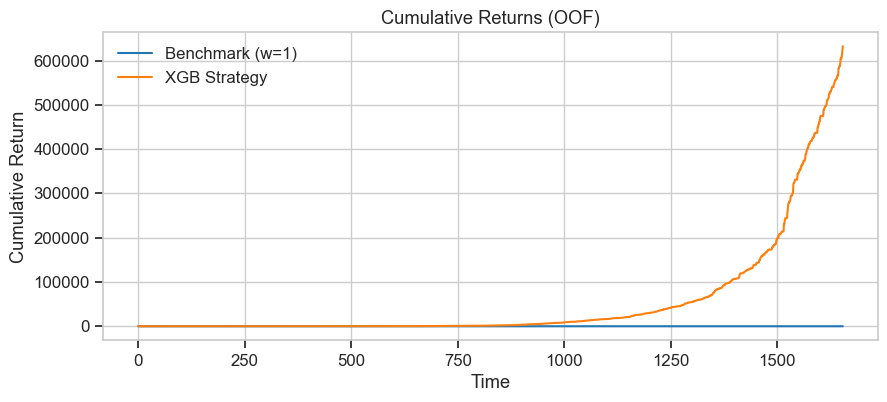

In [44]:
plt.figure(figsize=(10,4))
plt.plot((1 + strategy_results["ret_bench"]).cumprod() - 1, label="Benchmark (w=1)")
plt.plot((1 + strategy_results["ret_strat"]).cumprod() - 1, label="XGB Strategy")
plt.legend()
plt.title("Cumulative Returns (OOF)")
plt.xlabel("Time")
plt.ylabel("Cumulative Return")
plt.show()

처음엔 dataset 안에 있는 forward_returns, risk_free_rate를 그대로 feature로 넣어
타깃을 거의 완벽하게 재현하는 model을 만들었고,
결과적으로 OOF Sharpe 10, 63만 배 수익 같은 현실성 없는 성과가 나왔다.
financial ML에서 target leakage를 특히 조심해야 하며, 실제 투자에서는 미래 정보를 포함하는 변수는 존재하지 않기 때문에 이런 성과는 EMH와 상충되는 비현실적 결과라는 점을 인지하였다.